
# Python API Examples

This notebook walks through the basics of the Riva Speech and Language AI Services.

## Learning objectives

- Understand how interact with Riva Speech and Natural Languages APIs, services and use cases

## Requirements and setup

To execute this notebook, please follow the setup steps in [README](./README.md).

We first generate some required libraries.

## Content
1. [Offline ASR Example](#1)
1. [Core NLP Service Examples](#2)
1. [TTS Service Example](#3)
1. [Riva NLP Service Examples](#4)





## Overview

NVIDIA Riva is a platform for building and deploying AI applications that fuse vision, speech and other sensors. It offers a complete workflow to build, train and deploy AI systems that can use visual cues such as gestures and gaze along with speech in context. With the Riva platform, you can:

- Build speech and visual AI applications using pretrained NVIDIA Neural Modules ([NeMo](https://github.com/NVIDIA/NeMo)) available at NVIDIA GPU Cloud ([NGC](https://ngc.nvidia.com/catalog/models?orderBy=modifiedDESC&query=%20label%3A%22NeMo%2FPyTorch%22&quickFilter=models&filters=)).

- Transfer learning: re-train your model on domain-specific data, with NVIDIA [NeMo](https://github.com/NVIDIA/NeMo). NeMo is a toolkit and platform that enables researchers to define and build new state-of-the-art speech and natural language processing models.

- Optimize neural network performance and latency using NVIDIA TensorRT 

- Deploy AI applications with TensorRT Inference Server:
    - Support multiple network formats: ONNX, TensorRT plans, PyTorch TorchScript models.
    - Deployement on multiple platforms: from datacenter to edge servers, via Helm to K8s cluster, on NVIDIA Volta/Turing GPUs or Jetson Xavier platforms.

See the below video for a demo of Riva capabilities.

In [ ]:
from IPython.display import IFrame

# Riva Youtube demo video
IFrame("https://www.youtube.com/embed/r264lBi1nMU?rel=0&amp;controls=0&amp;showinfo=0", width="560", height="315", frameborder="0", allowfullscreen=True)

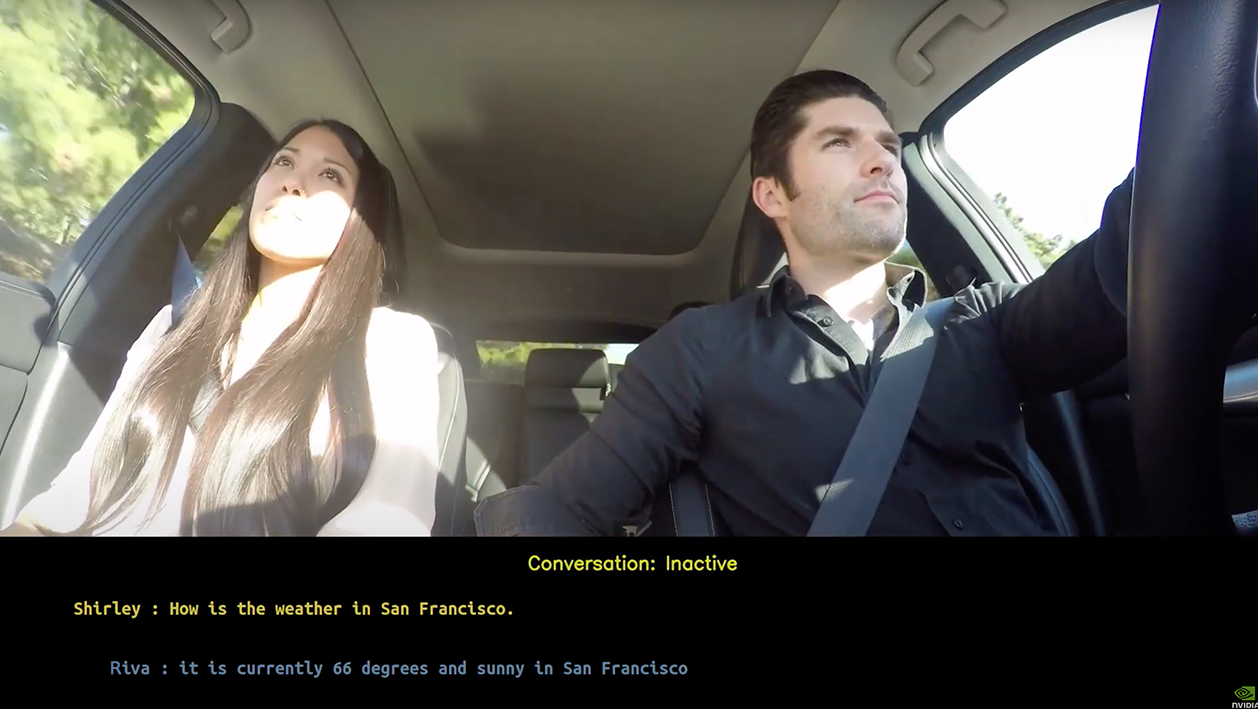

For more detailed information on Riva, please refer to the [Riva developer documentation](https://developer.nvidia.com/riva).

## Introduction the Riva Speech and Natural Languages services

Riva offers a rich set of speech and natural language understanding services such as:

- Automated speech recognition (ASR)
- Text-to-Speech synthesis (TTS)
- A collection of natural language understanding services such as named entity recognition (NER), punctuation, intent classification.

In [3]:
import io
import librosa
from time import time
import numpy as np
import IPython.display as ipd
import grpc
import requests

# NLP proto
import riva_api.riva_nlp_pb2 as rnlp
import riva_api.riva_nlp_pb2_grpc as rnlp_srv

# ASR proto
import riva_api.riva_asr_pb2 as rasr
import riva_api.riva_asr_pb2_grpc as rasr_srv

# TTS proto
import riva_api.riva_tts_pb2 as rtts
import riva_api.riva_tts_pb2_grpc as rtts_srv
import riva_api.riva_audio_pb2 as ra

### Create Riva clients and connect to Riva Speech API server

The below URI assumes a local deployment of the Riva Speech API server on the default port. In case the server deployment is on a different host or via Helm chart on Kubernetes, the user should use an appropriate URI.

In [4]:
##change this configuration to match your DGX number and your RIVA port number
##for example, 'dgx0180:50055'

channel = grpc.insecure_channel('localhost:50051')


riva_asr = rasr_srv.RivaSpeechRecognitionStub(channel)
riva_nlp = rnlp_srv.RivaLanguageUnderstandingStub(channel)
riva_tts = rtts_srv.RivaSpeechSynthesisStub(channel)

<a id="1"></a>

## 1. Offline ASR Example

Riva Speech API supports `.wav` files in PCM format, `.alaw`, `.mulaw` and `.flac` formats with single channel in this release. 

In [5]:
# This example uses a .wav file with LINEAR_PCM encoding.
# read in an audio file from local disk
path = "/work/wav/sample.wav"
audio, sr = librosa.core.load(path, sr=None)
with io.open(path, 'rb') as fh:
    content = fh.read()
ipd.Audio(path)

In [6]:
# Set up an offline/batch recognition request
req = rasr.RecognizeRequest()
req.audio = content                                   # raw bytes
req.config.encoding = ra.AudioEncoding.LINEAR_PCM     # Supports LINEAR_PCM, FLAC, MULAW and ALAW audio encodings
req.config.sample_rate_hertz = sr                     # Audio will be resampled if necessary
req.config.language_code = "en-US"                    # Ignored, will route to correct model in future release
req.config.max_alternatives = 1                       # How many top-N hypotheses to return
req.config.enable_automatic_punctuation = True        # Add punctuation when end of VAD detected
req.config.audio_channel_count = 1                    # Mono channel

response = riva_asr.Recognize(req)
asr_best_transcript = response.results[0].alternatives[0].transcript
print("ASR Transcript:", asr_best_transcript)

print("\n\nFull Response Message:")
print(response)

ASR Transcript: What is natural language processing? 


Full Response Message:
results {
  alternatives {
    transcript: "What is natural language processing? "
    confidence: -8.908161163330078
  }
  channel_tag: 1
  audio_processed: 6.400000095367432
}



<a id="2"></a>

## 2. Core NLP Service Examples

All of the Core NLP Services support batched requests. The maximum batch size,
if any, of the underlying models is hidden from the end user and automatically
batched by the Riva and TRTIS servers.

The Core NLP API provides three methods currently:

  1. TransformText - map an input string to an output string
  
  2. ClassifyText - return a single label for the input string
  
  3. ClassifyTokens - return a label per input token

In [7]:
# Use the TextTransform API to run the punctuation model
req = rnlp.TextTransformRequest()
req.model.model_name = "riva_punctuation"
req.text.append("add punctuation to this sentence")
req.text.append("do you have any red nvidia shirts")
req.text.append("i need one cpu four gpus and lots of memory "
                "for my new computer it's going to be very cool")

nlp_resp = riva_nlp.TransformText(req)
print("TransformText Output:")
print("\n".join([f" {x}" for x in nlp_resp.text]))

TransformText Output:
 Add punctuation to this sentence.
 Do you have any red Nvidia shirts?
 I need one cpu, four gpus and lots of memory for my new computer. It's going to be very cool.


In [8]:
# Use the TokenClassification API to run a Named Entity Recognition (NER) model
# Note: the model configuration of the NER model indicates that the labels are
# in IOB format. Riva, subsequently, knows to:
#   a) ignore 'O' labels
#   b) Remove B- and I- prefixes from labels
#   c) Collapse sequences of B- I- ... I- tokens into a single token

req = rnlp.TokenClassRequest()
req.model.model_name = "riva_ner"     # If you have deployed a custom model with the domain_name 
                                        # parameter in ServiceMaker's `riva-build` command then you should use 
                                        # "riva_ner_<your_input_domain_name>" where <your_input_domain_name>
                                        # is the name you provided to the domain_name parameter.

req.text.append("Jensen Huang is the CEO of NVIDIA Corporation, "
                "located in Santa Clara, California")
resp = riva_nlp.ClassifyTokens(req)

print("Named Entities:")
for result in resp.results[0].results:
    print(f"  {result.token} ({result.label[0].class_name})")

Named Entities:
  jensen huang (PER)
  nvidia corporation (ORG)
  santa clara (LOC)
  california (LOC)


In [9]:
# Submit a TextClassRequest for text classification.
# Riva NLP comes with a default text_classification domain called "domain_misty" which consists of 
# 4 classes: meteorology, personality, weather and nomatch

request = rnlp.TextClassRequest()
request.model.model_name = "riva_text_classification_domain"       # If you have deployed a custom model  
                                        # with the `--domain_name` parameter in ServiceMaker's `riva-build` command 
                                        # then you should use "riva_text_classification_<your_input_domain_name>"
                                        # where <your_input_domain_name> is the name you provided to the 
                                        # domain_name parameter. In this case the domain_name is "domain"
request.text.append("Is it going to snow in Burlington, Vermont tomorrow night?")
request.text.append("What causes rain?")
request.text.append("What is your favorite season?")
ct_response = riva_nlp.ClassifyText(request)
print(ct_response)

results {
  labels {
    class_name: "weather"
    score: 0.9975590109825134
  }
}
results {
  labels {
    class_name: "meteorology"
    score: 0.984375
  }
}
results {
  labels {
    class_name: "personality"
    score: 0.984375
  }
}



<a id="3"></a>

## 3. TTS Service Example

Subsequent releases will include added features, including model registration to support multiple languages/voices with the same API. Support for resampling to alternative sampling rates will also be added.

In [10]:
req = rtts.SynthesizeSpeechRequest()
req.text = "Is it recognize speech or wreck a nice beach?"
req.language_code = "en-US"                    # currently required to be "en-US"
req.encoding = ra.AudioEncoding.LINEAR_PCM     # Supports LINEAR_PCM, FLAC, MULAW and ALAW audio encodings
req.sample_rate_hz = 22050                     # ignored, audio returned will be 22.05KHz
req.voice_name = "ljspeech"                    # ignored

resp = riva_tts.Synthesize(req)
audio_samples = np.frombuffer(resp.audio, dtype=np.float32)
ipd.Audio(audio_samples, rate=22050)

<a id="4"></a>

## 4. Riva NLP Service Examples

The NLP Service contains higher-level/more application-specific NLP APIs. This
guide demonstrates how the AnalyzeIntent API can be used for queries across
both known and unknown domains.

In [11]:
# The AnalyzeIntent API can be used to query a Intent Slot classifier. The API can leverage a
# text classification model to classify the domain of the input query and then route to the 
# appropriate intent slot model.

# Lets first see an example where the domain is known. This skips execution of the domain classifier
# and proceeds directly to the intent/slot model for the requested domain.

req = rnlp.AnalyzeIntentRequest()
req.query = "How is the humidity in San Francisco?"
req.options.domain = "weather"  # The <domain_name> is appended to "riva_intent_" to look for a 
                                # model "riva_intent_<domain_name>". So in this e.g., the model "riva_intent_weather"
                                # needs to be preloaded in riva server. If you would like to deploy your 
                                # custom Joint Intent and Slot model use the `--domain_name` parameter in 
                                # ServiceMaker's `riva-build intent_slot` command.

resp = riva_nlp.AnalyzeIntent(req)
print(resp)

intent {
  class_name: "weather.humidity"
  score: 0.983601987361908
}
slots {
  token: "san francisco"
  label {
    class_name: "weatherplace"
    score: 0.9822959899902344
  }
}
slots {
  token: "?"
  label {
    class_name: "weatherplace"
    score: 0.6474800109863281
  }
}
domain_str: "weather"
domain {
  class_name: "weather"
  score: 1.0
}



In [12]:
# Below is an example where the input domain is not provided.

req = rnlp.AnalyzeIntentRequest()
req.query = "Is it going to rain tomorrow?"

        # The input query is first routed to the a text classification model called "riva_text_classification_domain"
        # The output class label of "riva_text_classification_domain" is appended to "riva_intent_"
        # to get the appropriate Intent Slot model to execute for the input query.
        # Note: The model "riva_text_classification_domain" needs to be loaded into Riva server and have the appropriate
        # class labels that would invoke the corresponding intent slot model.

resp = riva_nlp.AnalyzeIntent(req)
print(resp)

intent {
  class_name: "weather.rainfall"
  score: 0.9661880135536194
}
slots {
  token: "tomorrow"
  label {
    class_name: "weatherforecastdaily"
    score: 0.5325539708137512
  }
}
slots {
  token: "?"
  label {
    class_name: "weatherplace"
    score: 0.6895459890365601
  }
}
domain_str: "weather"
domain {
  class_name: "weather"
  score: 0.9975590109825134
}



In [13]:
# Some weather Intent queries
queries = [
    "Is it currently cloudy in Tokyo?",
    "What is the annual rainfall in Pune?",
    "What is the humidity going to be tomorrow?"
]
for q in queries:
    req = rnlp.AnalyzeIntentRequest()
    req.query = q
    start = time()
    resp = riva_nlp.AnalyzeIntent(req)

    print(f"[{resp.intent.class_name}]\t{req.query}")

[weather.cloudy]	Is it currently cloudy in Tokyo?
[weather.rainfall]	What is the annual rainfall in Pune?
[weather.humidity]	What is the humidity going to be tomorrow?


In [14]:
# Demonstrate latency by calling repeatedly.
# NOTE: this is a synchronous API call, so request #N will not be sent until
# response #N-1 is returned. This means latency and throughput will be negatively
# impacted by long-distance & VPN connections

req = rnlp.TextTransformRequest()
req.text.append("i need one cpu four gpus and lots of memory for my new computer it's going to be very cool")

iterations = 10
# Demonstrate synchronous performance
start_time = time()
for _ in range(iterations):
    nlp_resp = riva_nlp.PunctuateText(req)
end_time = time()
print(f"Time to complete {iterations} synchronous requests: {end_time-start_time}")

# Demonstrate async performance
start_time = time()
futures = []
for _ in range(iterations):
    futures.append(riva_nlp.PunctuateText.future(req))
for f in futures:
    f.result()
end_time = time()
print(f"Time to complete {iterations} asynchronous requests: {end_time-start_time}\n")


Time to complete 10 synchronous requests: 0.05957150459289551
Time to complete 10 asynchronous requests: 0.020952463150024414



<a id="5"></a>

## 5. Go deeper into Riva capabilities

Now that you have a basic introduction to the Riva APIs, you may like to try out:

### 1. Sample apps:

Riva comes with various sample apps as a demonstration for how to use the APIs to build interesting applications such as a [chatbot](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/samples/weather.html), a domain specific speech recognition or [keyword (entity) recognition system](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/samples/callcenter.html), or simply how Riva allows scaling out for handling massive amount of requests at the same time. ([SpeechSquad)](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/samples/speechsquad.html) 
Have a look at the Sample Application section in the [Riva developer documentation](https://developer.nvidia.com/riva) for all the sample apps.


### 2. Finetune your own domain specific Speech or NLP model and deploy into Riva.

Train the latest state-of-the-art speech and natural language processing models on your own data using [NeMo](https://github.com/NVIDIA/NeMo) or [Transfer Learning ToolKit](https://developer.nvidia.com/transfer-learning-toolkit) and deploy them on Riva using the [Riva ServiceMaker tool](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/model-servicemaker.html).


### 3. Further resources:

Explore the details of each of the APIs and their functionalities in the [docs](https://docs.nvidia.com/deeplearning/jarvis/user-guide/docs/protobuf-api/protobuf-api-root.html).